# Simple model using total square feet and number of bedrooms

In [1]:
%matplotlib inline

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import sklearn.linear_model
import pprint

## Load data

In [3]:
train_file = "../data/train.csv"
train_full = pd.read_csv(train_file, index_col=0)

test_file = "../data/test.csv"
test_full = pd.read_csv(test_file, index_col=0)

## Simplify data

In [4]:
output = "SalePrice"
# Note: GrLivArea = 1stFlrSF+2ndFlrSF+LowQualFinSF
features_simple = ["1stFlrSF", "2ndFlrSF", "LowQualFinSF", "GrLivArea", 
                   "BsmtFinSF1", "BsmtFinSF2", 
                   "BedroomAbvGr",
                   "FullBath", "HalfBath", "BsmtFullBath", "BsmtHalfBath",
                   ]

# Without .copy(), you're referencing a slice of the original.  Not good!
train = train_full[[output] + features_simple].copy()
test  =  test_full[features_simple].copy()

data = [train, test]

In [5]:
train.describe()

,SalePrice,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFinSF1,BsmtFinSF2,BedroomAbvGr,FullBath,HalfBath,BsmtFullBath,BsmtHalfBath
count,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,180921.195890,1162.626712,346.992466,5.844521,1515.463699,443.639726,46.549315,2.866438,1.565068,0.382877,0.425342,0.057534
std,79442.502883,386.587738,436.528436,48.623081,525.480383,456.098091,161.319273,0.815778,0.550916,0.502885,0.518911,0.238753
min,34900.000000,334.000000,0.000000,0.000000,334.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,129975.000000,882.000000,0.000000,0.000000,1129.500000,0.000000,0.000000,2.000000,1.000000,0.000000,0.000000,0.000000
50%,163000.000000,1087.000000,0.000000,0.000000,1464.000000,383.500000,0.000000,3.000000,2.000000,0.000000,0.000000,0.000000
75%,214000.000000,1391.250000,728.000000,0.000000,1776.750000,712.250000,0.000000,3.000000,2.000000,1.000000,1.000000,0.000000
max,755000.000000,4692.000000,2065.000000,572.000000,5642.000000,5644.000000,1474.000000,8.000000,3.000000,2.000000,3.000000,2.000000


In [6]:
test.describe()

,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFinSF1,BsmtFinSF2,BedroomAbvGr,FullBath,HalfBath,BsmtFullBath,BsmtHalfBath
count,1459.000000,1459.000000,1459.000000,1459.000000,1458.000000,1458.000000,1459.000000,1459.000000,1459.000000,1457.000000,1457.000000
mean,1156.534613,325.967786,3.543523,1486.045922,439.203704,52.619342,2.854010,1.570939,0.377656,0.434454,0.065202
std,398.165820,420.610226,44.043251,485.566099,455.268042,176.753926,0.829788,0.555190,0.503017,0.530648,0.252468
min,407.000000,0.000000,0.000000,407.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,873.500000,0.000000,0.000000,1117.500000,0.000000,0.000000,2.000000,1.000000,0.000000,0.000000,0.000000
50%,1079.000000,0.000000,0.000000,1432.000000,350.500000,0.000000,3.000000,2.000000,0.000000,0.000000,0.000000
75%,1382.500000,676.000000,0.000000,1721.000000,753.500000,0.000000,3.000000,2.000000,1.000000,1.000000,0.000000
max,5095.000000,1862.000000,1064.000000,5095.000000,4010.000000,1526.000000,6.000000,4.000000,2.000000,3.000000,2.000000


## Cleaning data

Test has a bad record that has a NAN BsmtFinSF1 and BsmtFinSF2 

In [7]:
ind = pd.isnull(test[['BsmtFinSF1', 'BsmtFinSF2']]).any(1).nonzero()[0]
print(ind) # 660th item, not INDEX 660
print(test.index[ind])

[660]
Int64Index([2121], dtype='int64', name='Id')


In [8]:
test.ix[test.index[ind]]

,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFinSF1,BsmtFinSF2,BedroomAbvGr,FullBath,HalfBath,BsmtFullBath,BsmtHalfBath
Id,,,,,,,,,,,
2121,896,0,0,896,NaN,NaN,2,1,0,NaN,NaN


Since I have to make predictions for everything, replace that with the mean of the training data set's values...

In [9]:
# This first one is chained indexing and does not work!!!  It does not set anything
# test.ix[ind]['BsmtFinSF1'] = train['BsmtFinSF1'].mean()
# test.ix[ind]['BsmtFinSF2'] = train['BsmtFinSF2'].mean()

# This method is fast, and syntax is (index, column name, value)
test.set_value(test.index[ind], 'BsmtFinSF1', train['BsmtFinSF1'].mean())
test.set_value(test.index[ind], 'BsmtFinSF2', train['BsmtFinSF2'].mean())

,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFinSF1,BsmtFinSF2,BedroomAbvGr,FullBath,HalfBath,BsmtFullBath,BsmtHalfBath
Id,,,,,,,,,,,
1461,896,0,0,896,468.0,144.0,2,1,0,0.0,0.0
1462,1329,0,0,1329,923.0,0.0,3,1,1,0.0,0.0
1463,928,701,0,1629,791.0,0.0,3,2,1,0.0,0.0
1464,926,678,0,1604,602.0,0.0,3,2,1,0.0,0.0
1465,1280,0,0,1280,263.0,0.0,2,2,0,0.0,0.0
1466,763,892,0,1655,0.0,0.0,3,2,1,0.0,0.0
1467,1187,0,0,1187,935.0,0.0,3,2,0,1.0,0.0
1468,789,676,0,1465,0.0,0.0,3,2,1,0.0,0.0
1469,1341,0,0,1341,637.0,0.0,2,1,1,1.0,0.0


In [10]:
test.ix[test.index[ind]]

,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFinSF1,BsmtFinSF2,BedroomAbvGr,FullBath,HalfBath,BsmtFullBath,BsmtHalfBath
Id,,,,,,,,,,,
2121,896,0,0,896,443.639726,46.549315,2,1,0,NaN,NaN


## Engineer new features

Total sqft living

In [11]:
def feat_eng_polys(df, feat, pwrs, inplace=True):
    """
    Given a dataframe and a feature, return a new (add to existing?) dataframe new features that are the pwrs'th power of the feature.
    
    :param pwrs:
        NOT IMPLEMENTED If pwrs=int, return all powers from 1 to that number.
        NOT IMPLEMENTED If pwrs=float, return that power.
        If pwrs=iterable, return the powers included in pwrs
    """
    if inplace is not True:
        df_new = pd.DataFrame(index=df.index)
    else:
        df_new = df
    for p in pwrs:
        df_new['{:s}_{:s}'.format(feat, str(p))] = df[feat] ** p

    # Does it matter if this gets returned when doing inplace=True?
    return df_new

In [12]:
for d in data:
    # Total sqft living (finished)
    d.loc[:,'TotLivSF'] = d['GrLivArea'] + d["BsmtFinSF1"] + d["BsmtFinSF2"]
    d.loc[:,'TotLivSF_sqrt'] = np.sqrt(d['TotLivSF'])
    
    # Functions of Total sqft Living (finished)
    # powers 2 to 5
    feat_eng_polys(d, 'TotLivSF', range(2,6))
    
    # Total bathrooms (halves included as 0.5 each)
    d.loc[:,'TotBath'] = d['FullBath'] + d['BsmtFullBath'] + 0.5 * (d['HalfBath'] + d['BsmtHalfBath'])
    

## Visualize Data

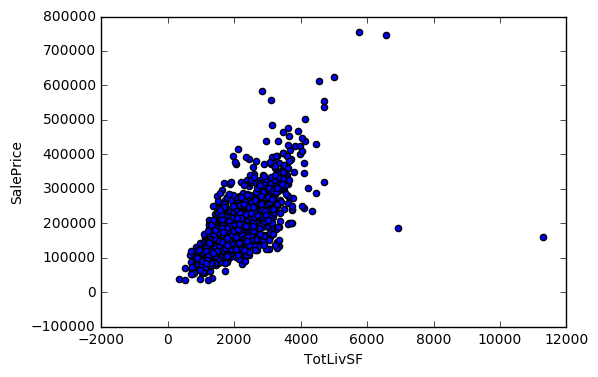

In [13]:
train.plot(x='TotLivSF', y='SalePrice', kind='scatter')

Remove the few houses above 5500 sqft as they seem pretty different from the others and there isn't enough data there for a good 
fit anyway

In [14]:
train[train['TotLivSF'] > 5500]

,SalePrice,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFinSF1,BsmtFinSF2,BedroomAbvGr,FullBath,HalfBath,BsmtFullBath,BsmtHalfBath,TotLivSF,TotLivSF_sqrt,TotLivSF_2,TotLivSF_3,TotLivSF_4,TotLivSF_5,TotBath
Id,,,,,,,,,,,,,,,,,,,
524,184750,3138,1538,0,4676,2260,0,3,3,1,1,0,6936,83.282651,48108096,333677753856,2314388900745216,-9223372036854775808,4.5
692,755000,2444,1872,0,4316,1455,0,4,3,1,0,1,5771,75.967098,33304441,192199929011,1109185790322481,6401111195951037440,4.0
1183,745000,2411,2065,0,4476,2096,0,4,3,1,1,0,6572,81.067873,43191184,283852461248,1865478375321856,-9223372036854775808,4.5
1299,160000,4692,950,0,5642,5644,0,3,2,1,2,0,11286,106.235587,127373796,1437540661656,16224083907449616,-9223372036854775808,4.5


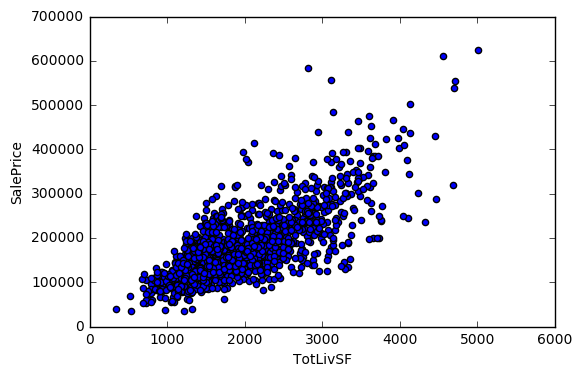

In [15]:
train = train[train['TotLivSF'] < 5500]
train.plot(x='TotLivSF', y='SalePrice', kind='scatter')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001AC2984B320>]], dtype=object)

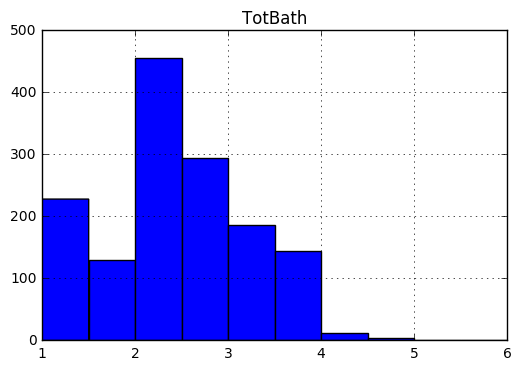

In [16]:
train.hist(column='TotBath')

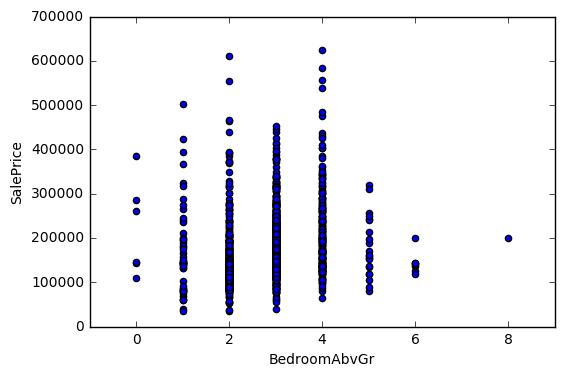

In [17]:
train.plot(x='BedroomAbvGr', y='SalePrice', kind='scatter')

Remove the really high bedroom count.  Should I remove 0 and 6 as well?

In [18]:
train = train[train['BedroomAbvGr'] <= 6]

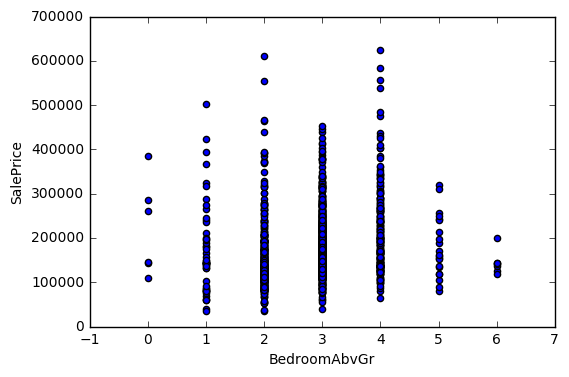

In [19]:
train.plot(x='BedroomAbvGr', y='SalePrice', kind='scatter')

# Make Models with TotLivSF

## Split the training set
For feature selection, split training into a training subset and a validation set.  Use the test set (which is evaluated through Kaggle) as the true test set.

In [34]:
# Split with random_state=something to always be consistent
train_sub, valid = train_test_split(train, test_size=0.25, random_state=42)

### First, try Linear Regression with varying complexities

In [35]:
all_features = ['TotLivSF'] + ['TotLivSF_{}'.format(i) for i in range(2,6)]
print(all_features)

['TotLivSF', 'TotLivSF_2', 'TotLivSF_3', 'TotLivSF_4', 'TotLivSF_5']


Make and train a model for TotLivSF, [TotLivSF, TotLivSF_2], [TotLivSF, TotLivSF_2, TotLivSF_3], ...

In [36]:
def train_models(model, model_kwargs, df, all_features, target):
    models = [model(**model_kwargs) for i in all_features]
    for i,m in enumerate(models):
        fs = all_features[:i+1] # include 0 to ith feature
        m.fit(df[fs], df[target])
    return models

def predict_models(models, df, all_features):
    predictions = [None] * len(models)
    for i,m in enumerate(models):
        fs = all_features[:i+1] # include 0 to ith feature
        predictions[i] = m.predict(df[fs])
    return predictions

def visualize_prediction(truthX, truthY, predictionY):
    plt.plot(truthX, truthY, 'b.',
            truthX, predictionY, 'g.')
    plt.show()


In [37]:
def get_RSS(d1, d2):
    return ((np.asarray(d1) - np.asarray(d2)) ** 2).sum()
def get_RMS(d1, d2):
    return np.sqrt(get_RSS(d1, d2)) / len(d1)

Train the models

In [38]:
m_linear = train_models(sklearn.linear_model.LinearRegression, {'normalize':True}, train_sub, all_features, ['SalePrice'])

Make predictions with all the models

In [39]:
p_linear = predict_models(m_linear, valid, all_features)
p_linear_train = predict_models(m_linear, train_sub, all_features)

Visualize the predictions

0: Features = ['TotLivSF']


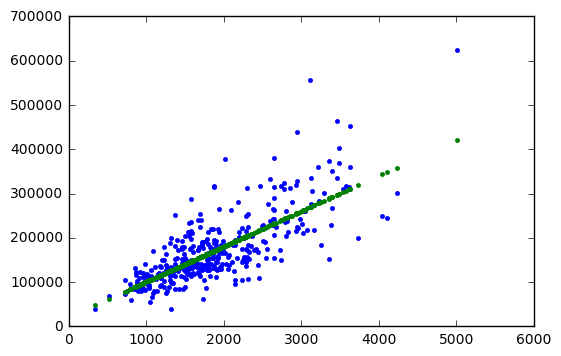

1: Features = ['TotLivSF', 'TotLivSF_2']


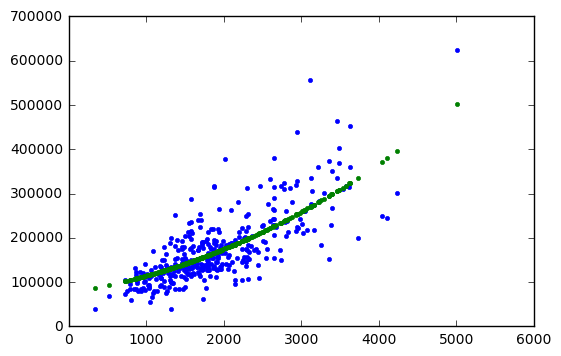

2: Features = ['TotLivSF', 'TotLivSF_2', 'TotLivSF_3']


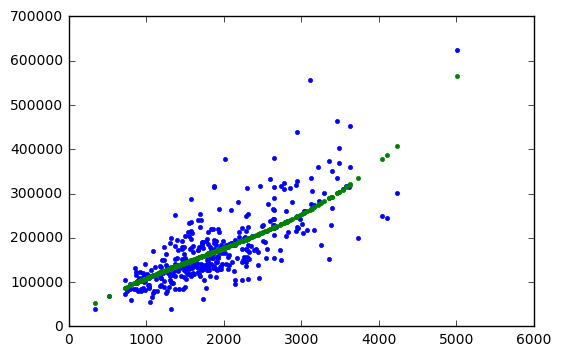

3: Features = ['TotLivSF', 'TotLivSF_2', 'TotLivSF_3', 'TotLivSF_4']


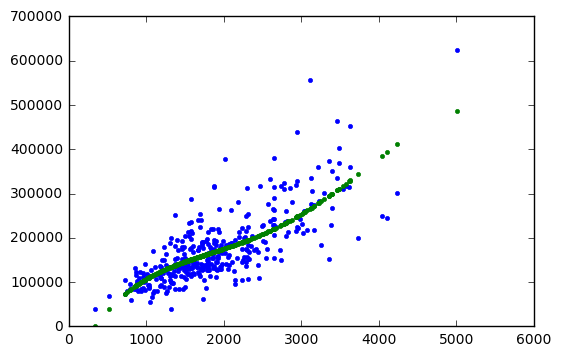

4: Features = ['TotLivSF', 'TotLivSF_2', 'TotLivSF_3', 'TotLivSF_4', 'TotLivSF_5']


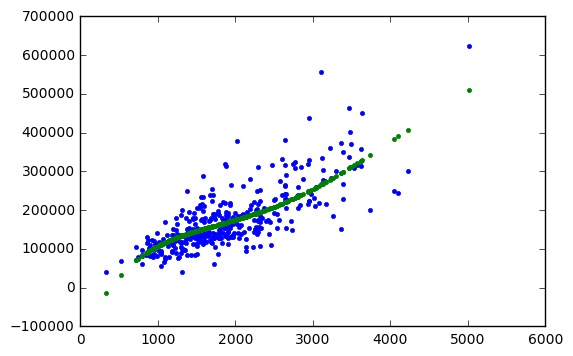

In [40]:
for i in range(len(p_linear)):
    fs = all_features[:i+1]
    print("{}: Features = {}".format(i, fs))
    visualize_prediction(valid['TotLivSF'], valid['SalePrice'], p_linear[i])

Evaluate each model on the validation data

In [41]:
RSS_linear = [None] * len(m_linear)
RMS_linear = [None] * len(m_linear)
for i,m in enumerate(m_linear):
    RSS_linear[i] = get_RSS(valid[['SalePrice']], p_linear[i])
    RMS_linear[i] = get_RMS(valid[['SalePrice']], p_linear[i])
    print("{}: RSS={:8e}, RMS={:8.2f}".format(i, RSS_linear[i], RMS_linear[i]))

0: RSS=9.640371e+11, RMS= 2697.40
1: RSS=9.540953e+11, RMS= 2683.46
2: RSS=9.498630e+11, RMS= 2677.50
3: RSS=9.680402e+11, RMS= 2703.00
4: RSS=9.607945e+11, RMS= 2692.86


#### Submit the best performing model

First check syntax...

In [42]:
fs = ['TotLivSF', 'TotLivSF_2', 'TotLivSF_3', 'TotLivSF_4']
test_predictions_linear = pd.DataFrame(m_linear[3].predict(valid[fs]), index=valid.index, columns=['SalePrice'])
test_predictions_linear.index.name = "Id"
get_RMS(valid[['SalePrice']], test_predictions_linear)

2702.9954604036643

Same as above, like it should be.  Now, for real!

In [43]:
fs = ['TotLivSF', 'TotLivSF_2', 'TotLivSF_3', 'TotLivSF_4']
test_predictions_linear = pd.DataFrame(m_linear[3].predict(test[fs]), index=test.index, columns=['SalePrice'])
test_predictions_linear.index.name = "Id"


But, there is a problem with this model... One of the test data points has a very large square footage, leading to an issue with the prediction...

In [44]:
print(test.loc[[2550]])
print(test_predictions_linear.loc[[2550]])

      1stFlrSF  2ndFlrSF  LowQualFinSF  GrLivArea  BsmtFinSF1  BsmtFinSF2  \
Id                                                                          
2550      5095         0             0       5095      4010.0         0.0   

      BedroomAbvGr  FullBath  HalfBath  BsmtFullBath  BsmtHalfBath  TotLivSF  \
Id                                                                             
2550             2         2         1           1.0           1.0    9105.0   

      TotLivSF_sqrt  TotLivSF_2    TotLivSF_3    TotLivSF_4    TotLivSF_5  \
Id                                                                          
2550      95.420124  82901025.0  7.548138e+11  6.872580e+15  6.257484e+19   

      TotBath  
Id             
2550      4.0  
         SalePrice
Id                
2550 -4.682166e+06


We can see this problem by plotting the model vs sqft

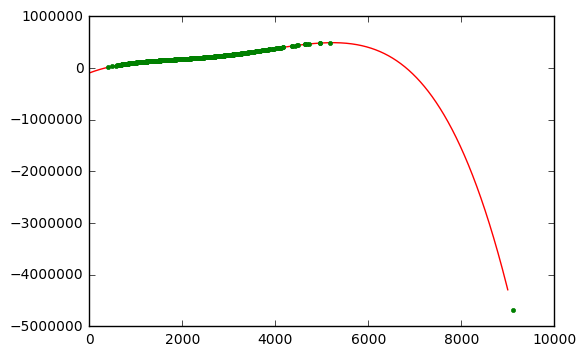

In [45]:
df = pd.DataFrame({'TotLivSF':   [i**1 for i in range(0,9000)],
                   'TotLivSF_2': [i**2 for i in range(0,9000)],
                   'TotLivSF_3': [i**3 for i in range(0,9000)],
                   'TotLivSF_4': [i**4 for i in range(0,9000)],

})
sample_predictions_linear = pd.DataFrame(m_linear[3].predict(df[fs]), columns=['SalePrice'])
plt.plot(#test['TotLivSF'], test['SalePrice'], 'b.',
         df['TotLivSF'], sample_predictions_linear, 'r-',
         test['TotLivSF'], test_predictions_linear['SalePrice'], 'g.')


Not sure the best systematic way to address this.  Manually override this data point with a value of 1.1M...  

In [46]:
test_predictions_linear.loc[2550,['SalePrice']] = 1100000
print(test_predictions_linear.loc[[2550]])

      SalePrice
Id             
2550  1100000.0


In [47]:
test_predictions_linear.to_csv('test_predictions_linear_1.csv')

### Try with Ridge Regression, manually choosing alpha

Train the models

In [48]:
alphas = np.logspace(-6,5,12)
print(alphas)
m_Ridge = [None] * len(alphas)
for i in range(len(m_Ridge)):
    m_Ridge[i] = train_models(sklearn.linear_model.Ridge, {'normalize':True, 'alpha':alphas[i]}, train_sub, all_features, ['SalePrice'])

[  1.00000000e-06   1.00000000e-05   1.00000000e-04   1.00000000e-03
   1.00000000e-02   1.00000000e-01   1.00000000e+00   1.00000000e+01
   1.00000000e+02   1.00000000e+03   1.00000000e+04   1.00000000e+05]


Make predictions with all the models

In [49]:
p_Ridge = [None] * len(alphas)
p_Ridge_train = [None] * len(alphas)
for i in range(len(p_Ridge)):
    p_Ridge[i] =       predict_models(m_Ridge[i], valid, all_features)
    p_Ridge_train[i] = predict_models(m_Ridge[i], train_sub, all_features)

Visualize the predictions

alpha=1e-06, Features=['TotLivSF']


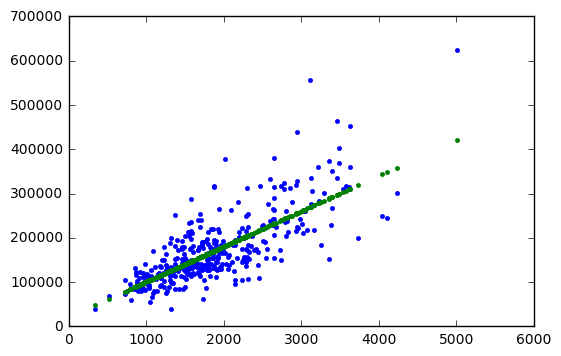

alpha=1e-06, Features=['TotLivSF', 'TotLivSF_2']


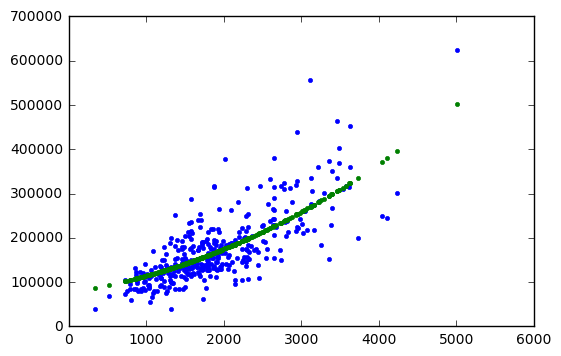

alpha=1e-06, Features=['TotLivSF', 'TotLivSF_2', 'TotLivSF_3']


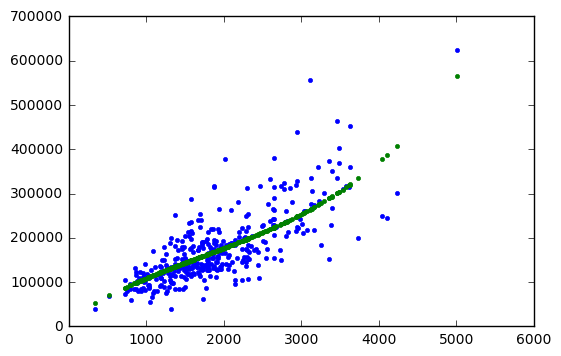

alpha=1e-06, Features=['TotLivSF', 'TotLivSF_2', 'TotLivSF_3', 'TotLivSF_4']


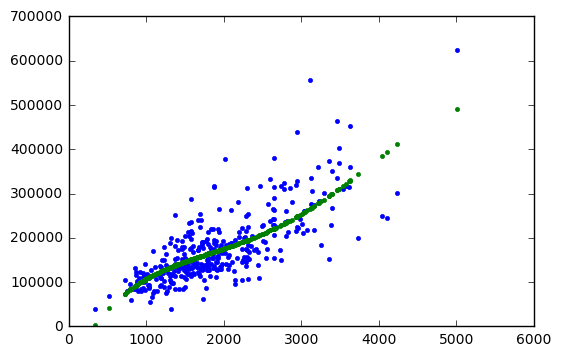

alpha=1e-06, Features=['TotLivSF', 'TotLivSF_2', 'TotLivSF_3', 'TotLivSF_4', 'TotLivSF_5']


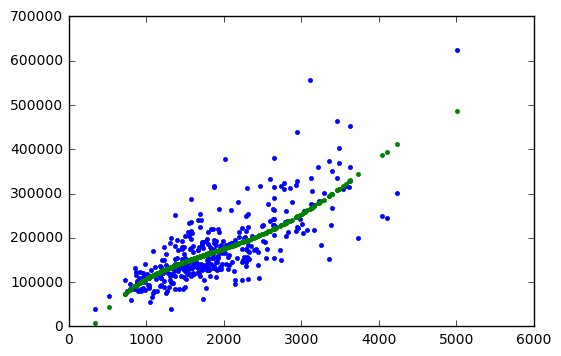

alpha=1e-05, Features=['TotLivSF']


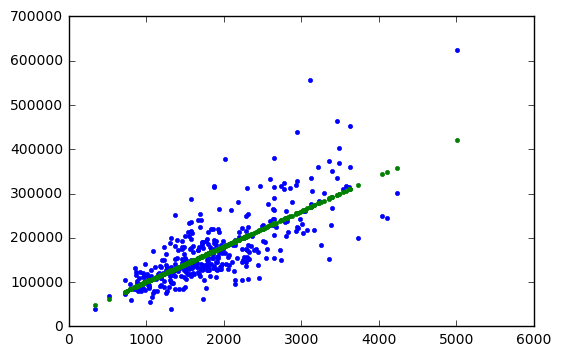

alpha=1e-05, Features=['TotLivSF', 'TotLivSF_2']


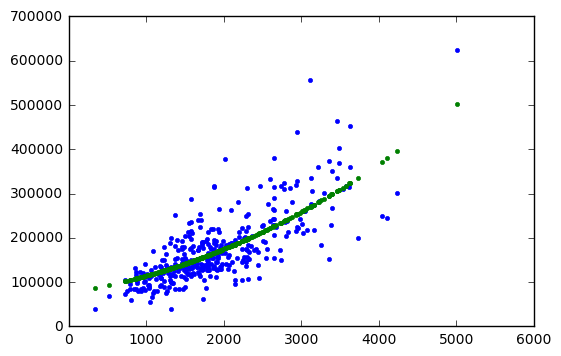

alpha=1e-05, Features=['TotLivSF', 'TotLivSF_2', 'TotLivSF_3']


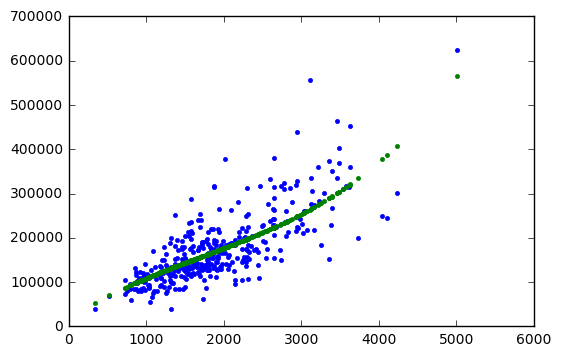

alpha=1e-05, Features=['TotLivSF', 'TotLivSF_2', 'TotLivSF_3', 'TotLivSF_4']


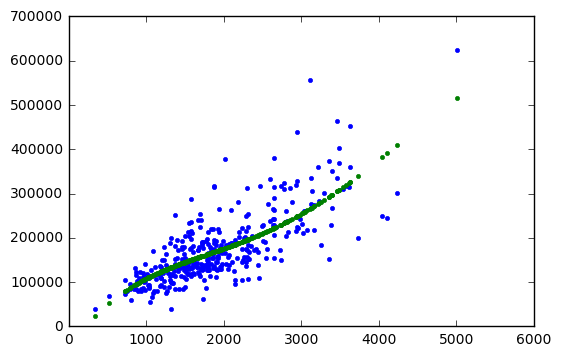

alpha=1e-05, Features=['TotLivSF', 'TotLivSF_2', 'TotLivSF_3', 'TotLivSF_4', 'TotLivSF_5']


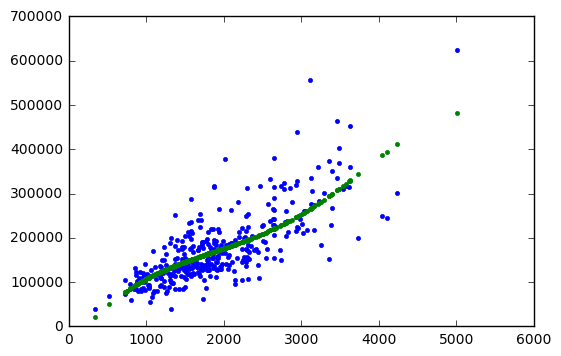

alpha=0.0001, Features=['TotLivSF']


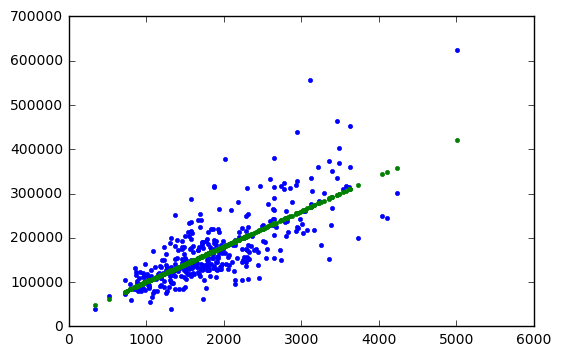

alpha=0.0001, Features=['TotLivSF', 'TotLivSF_2']


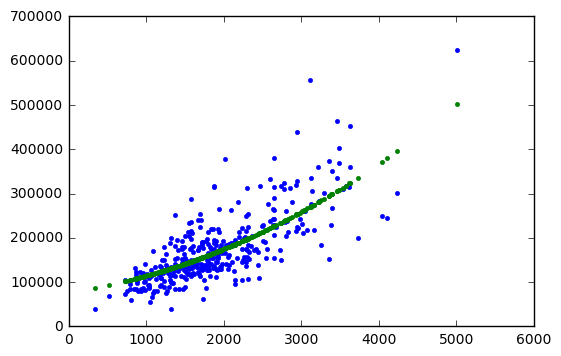

alpha=0.0001, Features=['TotLivSF', 'TotLivSF_2', 'TotLivSF_3']


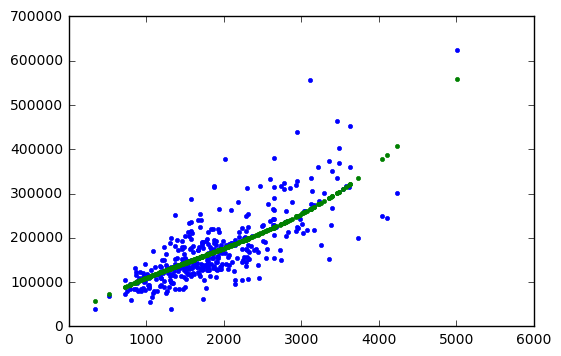

alpha=0.0001, Features=['TotLivSF', 'TotLivSF_2', 'TotLivSF_3', 'TotLivSF_4']


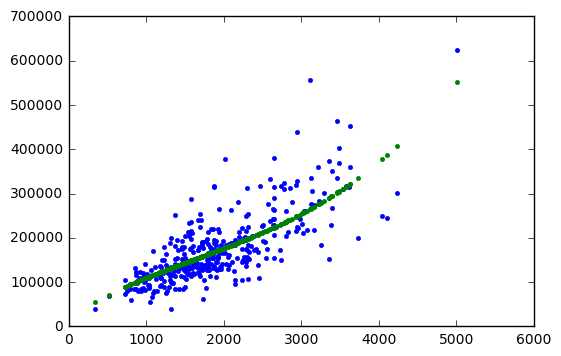

alpha=0.0001, Features=['TotLivSF', 'TotLivSF_2', 'TotLivSF_3', 'TotLivSF_4', 'TotLivSF_5']


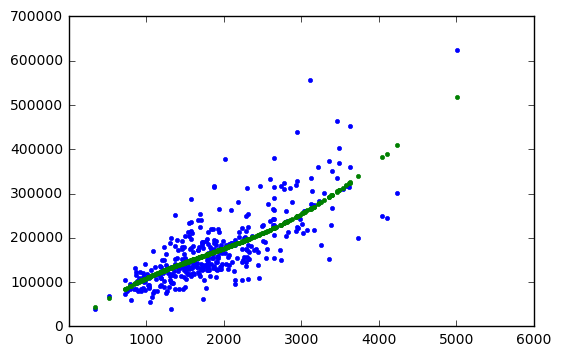

alpha=0.001, Features=['TotLivSF']


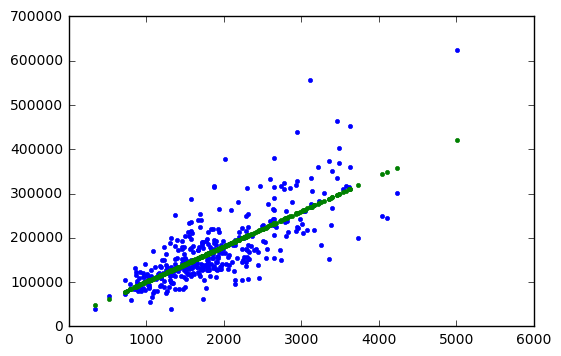

alpha=0.001, Features=['TotLivSF', 'TotLivSF_2']


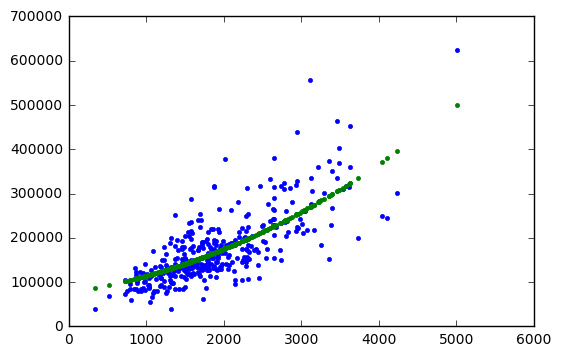

alpha=0.001, Features=['TotLivSF', 'TotLivSF_2', 'TotLivSF_3']


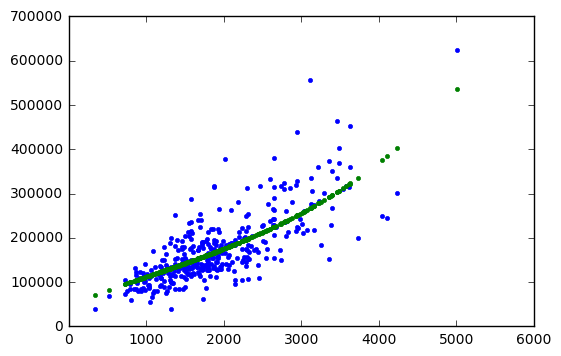

alpha=0.001, Features=['TotLivSF', 'TotLivSF_2', 'TotLivSF_3', 'TotLivSF_4']


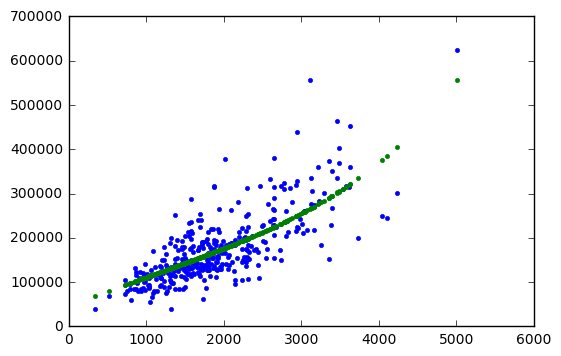

alpha=0.001, Features=['TotLivSF', 'TotLivSF_2', 'TotLivSF_3', 'TotLivSF_4', 'TotLivSF_5']


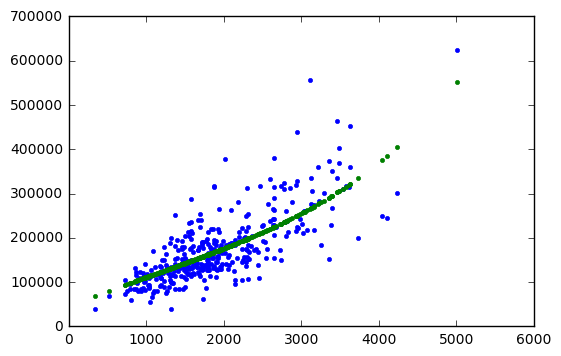

alpha=0.01, Features=['TotLivSF']


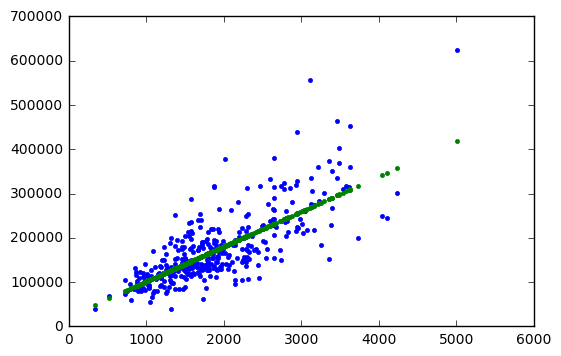

alpha=0.01, Features=['TotLivSF', 'TotLivSF_2']


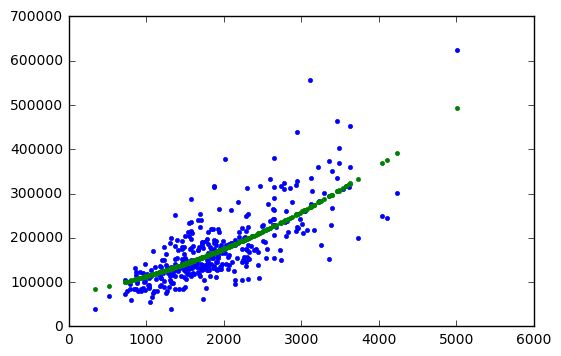

alpha=0.01, Features=['TotLivSF', 'TotLivSF_2', 'TotLivSF_3']


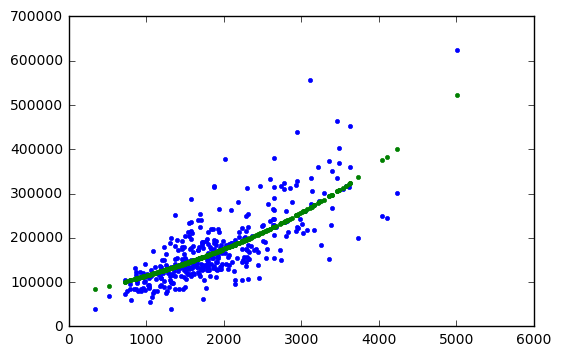

alpha=0.01, Features=['TotLivSF', 'TotLivSF_2', 'TotLivSF_3', 'TotLivSF_4']


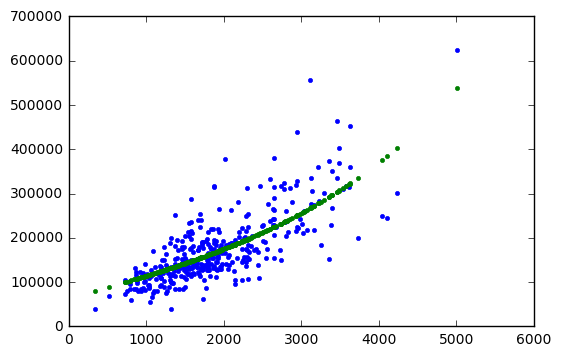

alpha=0.01, Features=['TotLivSF', 'TotLivSF_2', 'TotLivSF_3', 'TotLivSF_4', 'TotLivSF_5']


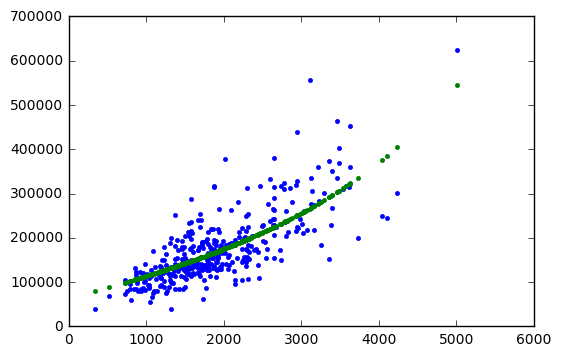

alpha=0.1, Features=['TotLivSF']


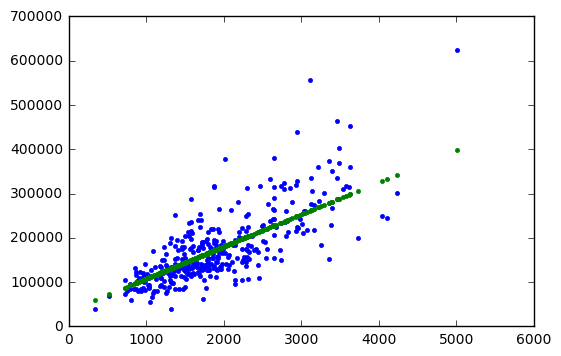

alpha=0.1, Features=['TotLivSF', 'TotLivSF_2']


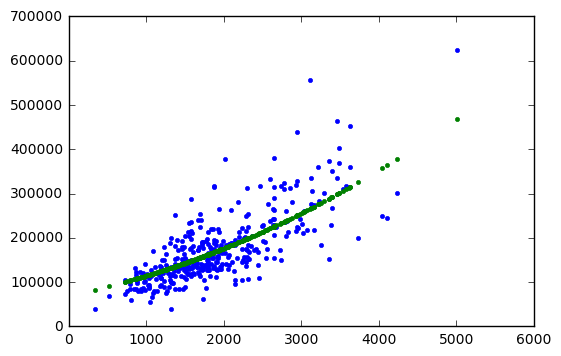

alpha=0.1, Features=['TotLivSF', 'TotLivSF_2', 'TotLivSF_3']


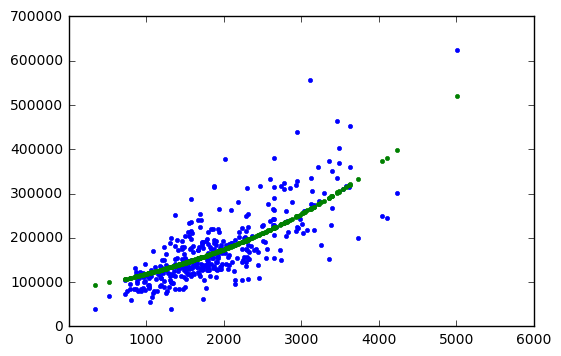

alpha=0.1, Features=['TotLivSF', 'TotLivSF_2', 'TotLivSF_3', 'TotLivSF_4']


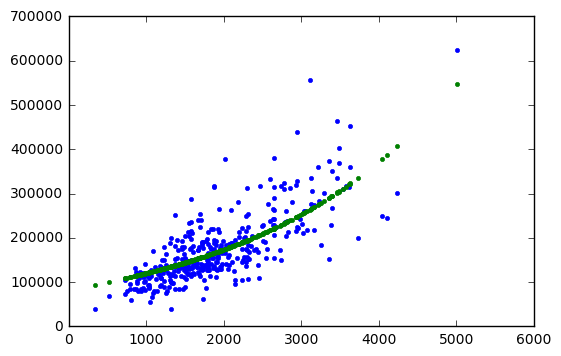

alpha=0.1, Features=['TotLivSF', 'TotLivSF_2', 'TotLivSF_3', 'TotLivSF_4', 'TotLivSF_5']


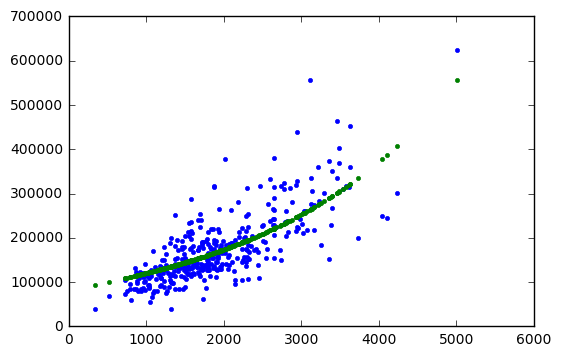

alpha=1.0, Features=['TotLivSF']


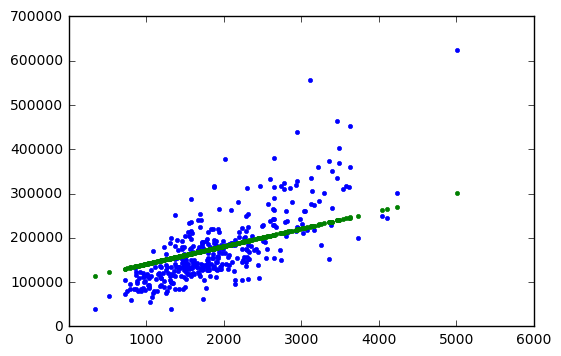

alpha=1.0, Features=['TotLivSF', 'TotLivSF_2']


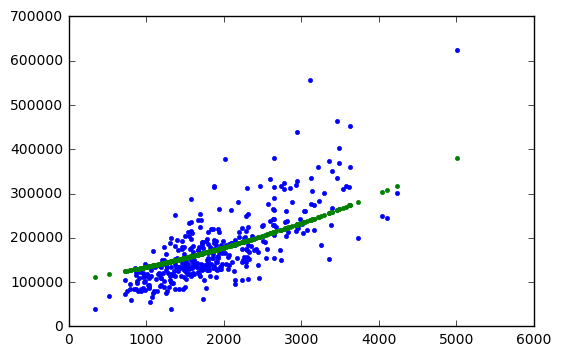

alpha=1.0, Features=['TotLivSF', 'TotLivSF_2', 'TotLivSF_3']


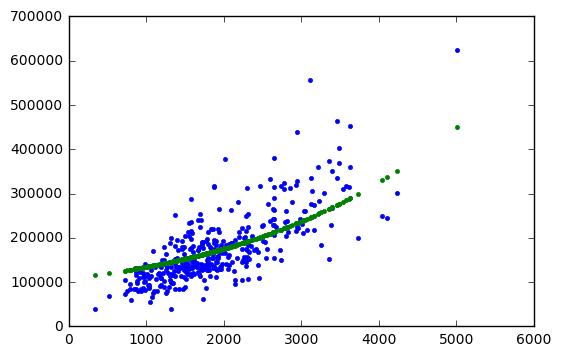

alpha=1.0, Features=['TotLivSF', 'TotLivSF_2', 'TotLivSF_3', 'TotLivSF_4']


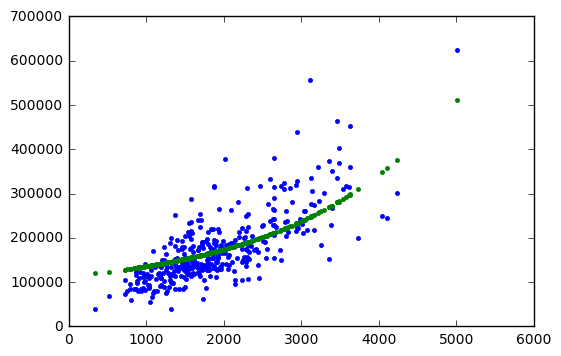

alpha=1.0, Features=['TotLivSF', 'TotLivSF_2', 'TotLivSF_3', 'TotLivSF_4', 'TotLivSF_5']


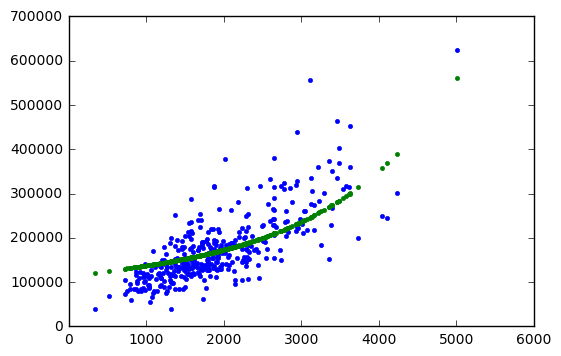

alpha=10.0, Features=['TotLivSF']


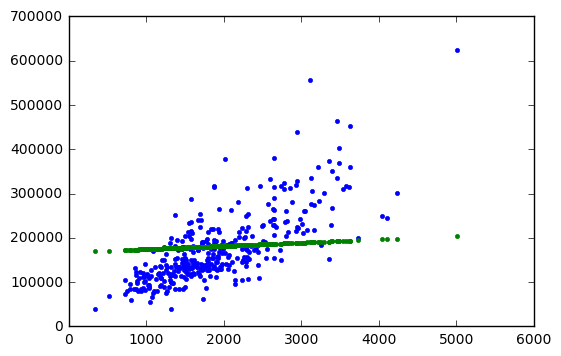

alpha=10.0, Features=['TotLivSF', 'TotLivSF_2']


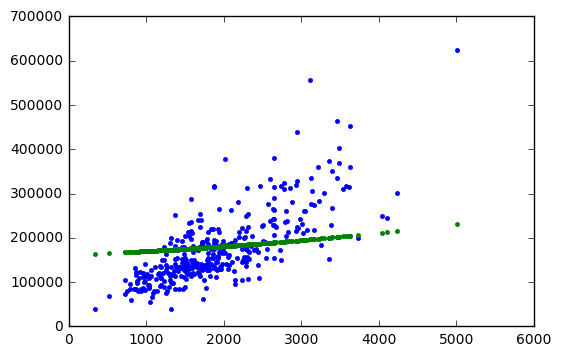

alpha=10.0, Features=['TotLivSF', 'TotLivSF_2', 'TotLivSF_3']


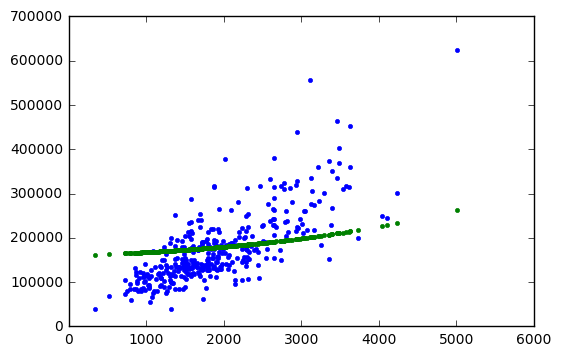

alpha=10.0, Features=['TotLivSF', 'TotLivSF_2', 'TotLivSF_3', 'TotLivSF_4']


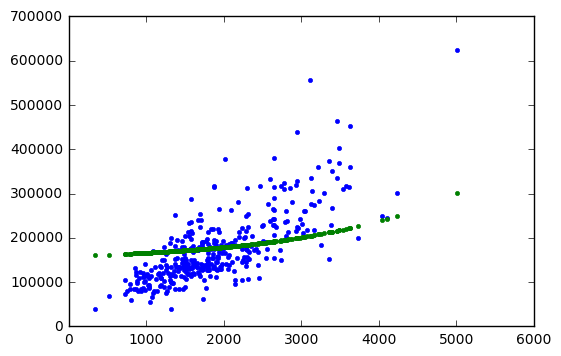

alpha=10.0, Features=['TotLivSF', 'TotLivSF_2', 'TotLivSF_3', 'TotLivSF_4', 'TotLivSF_5']


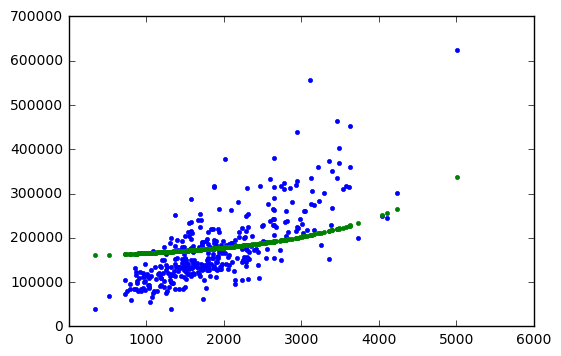

alpha=100.0, Features=['TotLivSF']


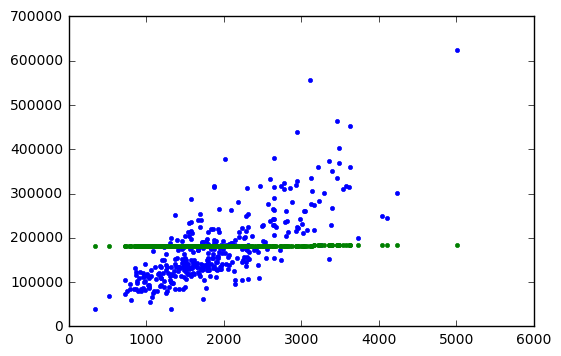

alpha=100.0, Features=['TotLivSF', 'TotLivSF_2']


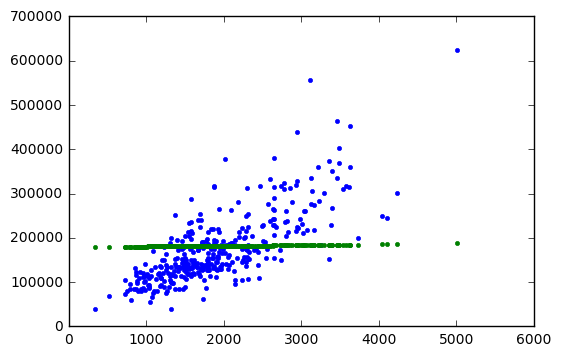

alpha=100.0, Features=['TotLivSF', 'TotLivSF_2', 'TotLivSF_3']


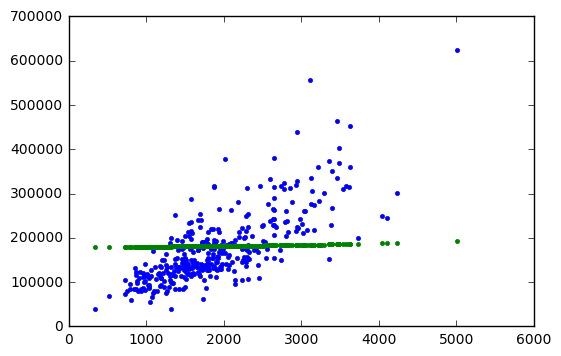

alpha=100.0, Features=['TotLivSF', 'TotLivSF_2', 'TotLivSF_3', 'TotLivSF_4']


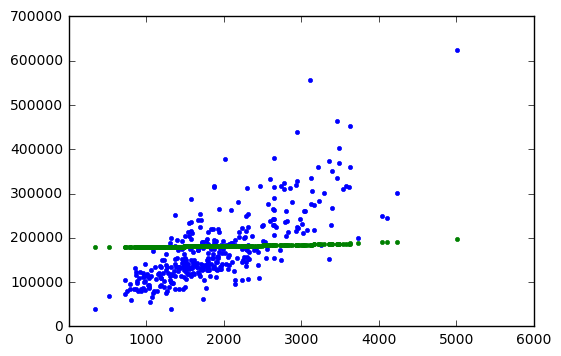

alpha=100.0, Features=['TotLivSF', 'TotLivSF_2', 'TotLivSF_3', 'TotLivSF_4', 'TotLivSF_5']


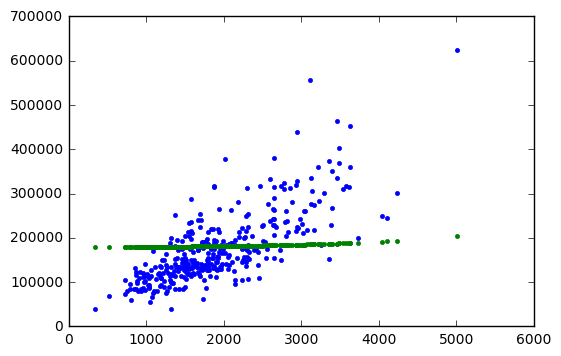

alpha=1000.0, Features=['TotLivSF']


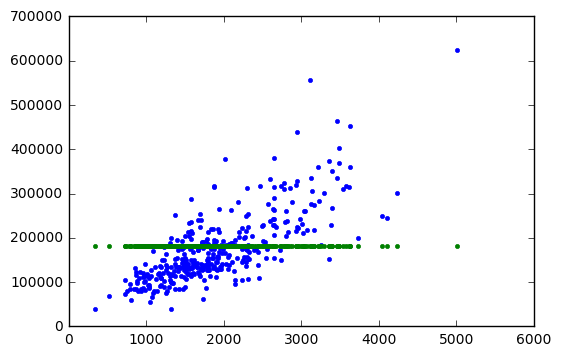

alpha=1000.0, Features=['TotLivSF', 'TotLivSF_2']


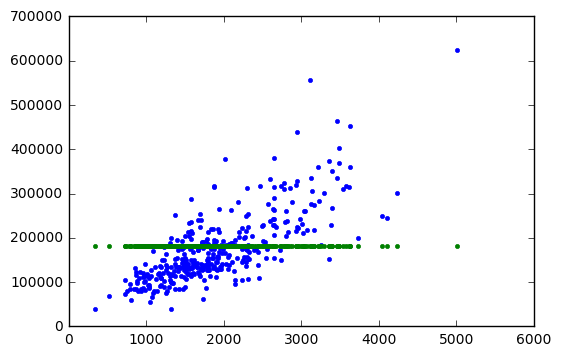

alpha=1000.0, Features=['TotLivSF', 'TotLivSF_2', 'TotLivSF_3']


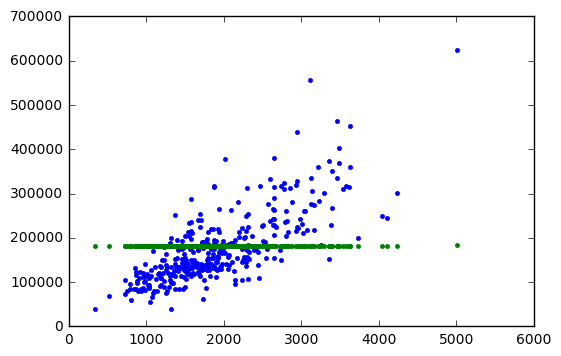

alpha=1000.0, Features=['TotLivSF', 'TotLivSF_2', 'TotLivSF_3', 'TotLivSF_4']


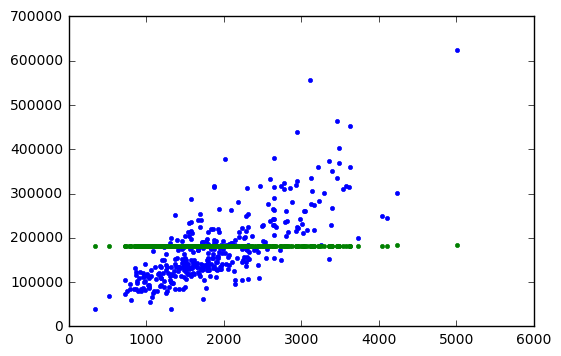

alpha=1000.0, Features=['TotLivSF', 'TotLivSF_2', 'TotLivSF_3', 'TotLivSF_4', 'TotLivSF_5']


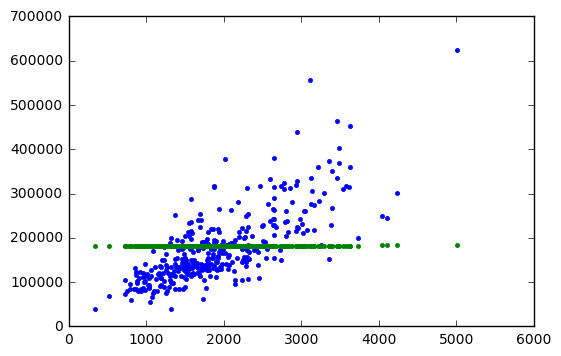

alpha=10000.0, Features=['TotLivSF']


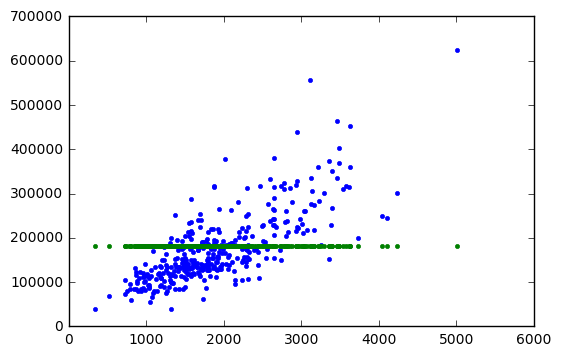

alpha=10000.0, Features=['TotLivSF', 'TotLivSF_2']


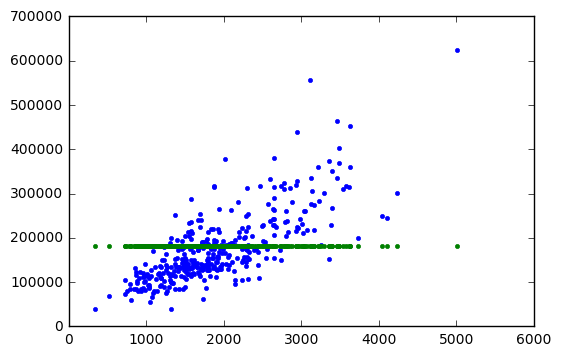

alpha=10000.0, Features=['TotLivSF', 'TotLivSF_2', 'TotLivSF_3']


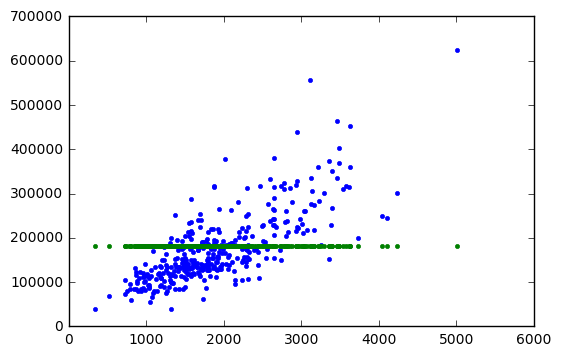

alpha=10000.0, Features=['TotLivSF', 'TotLivSF_2', 'TotLivSF_3', 'TotLivSF_4']


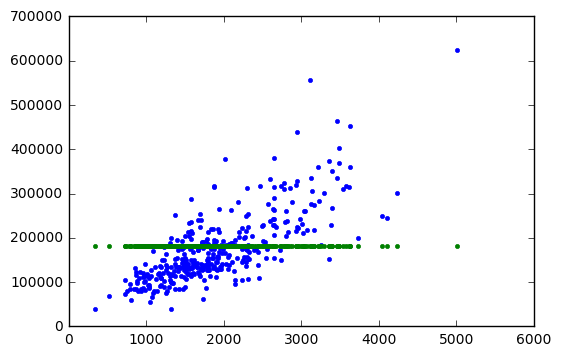

alpha=10000.0, Features=['TotLivSF', 'TotLivSF_2', 'TotLivSF_3', 'TotLivSF_4', 'TotLivSF_5']


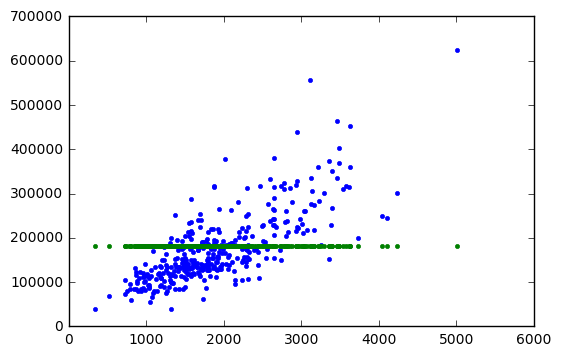

alpha=100000.0, Features=['TotLivSF']


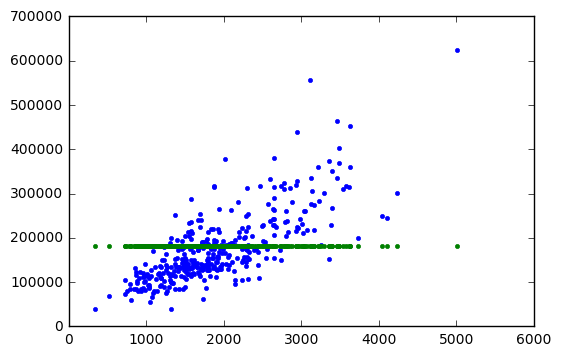

alpha=100000.0, Features=['TotLivSF', 'TotLivSF_2']


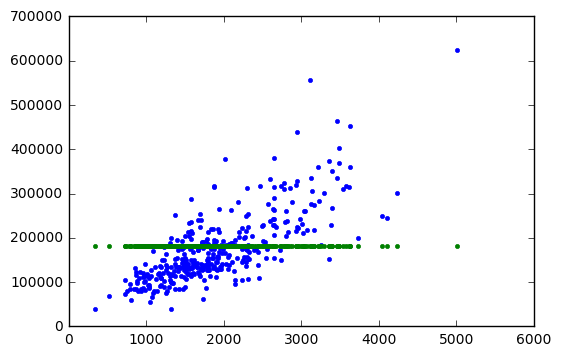

alpha=100000.0, Features=['TotLivSF', 'TotLivSF_2', 'TotLivSF_3']


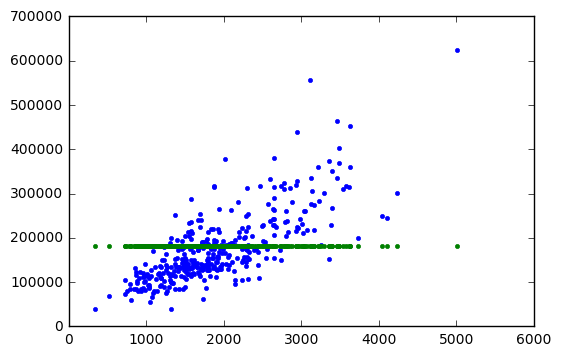

alpha=100000.0, Features=['TotLivSF', 'TotLivSF_2', 'TotLivSF_3', 'TotLivSF_4']


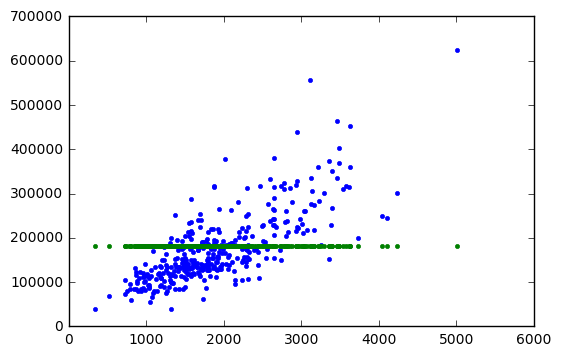

alpha=100000.0, Features=['TotLivSF', 'TotLivSF_2', 'TotLivSF_3', 'TotLivSF_4', 'TotLivSF_5']


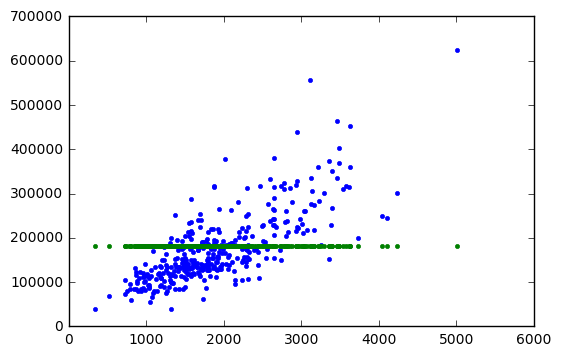

In [50]:
for j in range(len(p_Ridge)):
    for i in range(len(p_Ridge[j])):
        fs = all_features[:i+1]
        print("alpha={}, Features={}".format(alphas[j], fs))
        visualize_prediction(valid['TotLivSF'], valid['SalePrice'], p_Ridge[j][i])
    
#     for i in range(len(p_linear)):
#     fs = all_features[:i+1]
#     print("{}: Features = {}".format(i, fs))
#     visualize_prediction(valid['TotLivSF'], valid['SalePrice'], p_linear[i])

In [51]:
print("Compare coef values for each model at a given alpha")

for i in range(len(m_Ridge[0])):
    for j in range(len(alphas)):
        coefs_str = ""
        for c in m_Ridge[j][i].coef_[0]:
            coefs_str = coefs_str + "{:>6.2e}\t".format(c)
        
        print("a={:5.1e},\tc={}".format(alphas[i], coefs_str))
    

print("Look at effect of alpha on coefs...")

for i in range(len(m_Ridge[j])):
    for j in range(len(m_Ridge)):

        coefs_str = ""
        for c in m_Ridge[j][i].coef_[0]:
            coefs_str = coefs_str + "{:>6.2e}\t".format(c)
        
        print("a={:5.1e},\tc={}".format(alphas[j], coefs_str))

Compare coef values for each model at a given alpha
a=1.0e-06,	c=7.98e+01	
a=1.0e-06,	c=7.98e+01	
a=1.0e-06,	c=7.98e+01	
a=1.0e-06,	c=7.97e+01	
a=1.0e-06,	c=7.90e+01	
a=1.0e-06,	c=7.25e+01	
a=1.0e-06,	c=3.99e+01	
a=1.0e-06,	c=7.25e+00	
a=1.0e-06,	c=7.90e-01	
a=1.0e-06,	c=7.97e-02	
a=1.0e-06,	c=7.98e-03	
a=1.0e-06,	c=7.98e-04	
a=1.0e-05,	c=2.42e+01	1.20e-02	
a=1.0e-05,	c=2.42e+01	1.20e-02	
a=1.0e-05,	c=2.43e+01	1.20e-02	
a=1.0e-05,	c=2.49e+01	1.18e-02	
a=1.0e-05,	c=2.91e+01	1.09e-02	
a=1.0e-05,	c=3.56e+01	8.77e-03	
a=1.0e-05,	c=2.66e+01	5.76e-03	
a=1.0e-05,	c=6.66e+00	1.42e-03	
a=1.0e-05,	c=7.82e-01	1.67e-04	
a=1.0e-05,	c=7.96e-02	1.70e-05	
a=1.0e-05,	c=7.98e-03	1.70e-06	
a=1.0e-05,	c=7.98e-04	1.70e-07	
a=1.0e-04,	c=1.14e+02	-2.78e-02	5.37e-06	
a=1.0e-04,	c=1.13e+02	-2.73e-02	5.31e-06	
a=1.0e-04,	c=1.04e+02	-2.34e-02	4.79e-06	
a=1.0e-04,	c=6.72e+01	-7.62e-03	2.71e-06	
a=1.0e-04,	c=4.01e+01	3.67e-03	1.27e-06	
a=1.0e-04,	c=3.08e+01	5.39e-03	1.19e-06	
a=1.0e-04,	c=2.09e+01	4.32e-03	1.02e-0

In [52]:
RSS_Ridge = [None] * len(alphas)
RMS_Ridge = [None] * len(alphas)
for j in range(len(alphas)):
    RSS_Ridge[j] = [get_RSS(valid[['SalePrice']], p_Ridge[j][i]) for i in range(len(p_Ridge[j]))]
    RMS_Ridge[j] = [get_RMS(valid[['SalePrice']], p_Ridge[j][i]) for i in range(len(p_Ridge[j]))]
    
# pprint.pprint(RSS_Ridge)
# pprint.pprint(RMS_Ridge)

# Print using dataframe
RSS_Ridge_df = pd.DataFrame(RSS_Ridge, index=alphas, columns=range(1,len(RSS_Ridge[0])+1))
print("RSS")
print(RSS_Ridge_df)
print()
print("RSS (Normalized by minimum)")
RSS_Ridge_min = RSS_Ridge_df.min().min()
print(RSS_Ridge_df/RSS_Ridge_min)

# Print using dataframe
RMS_Ridge_df = pd.DataFrame(RMS_Ridge, index=alphas, columns=range(1,len(RMS_Ridge[0])+1))
print("RMS")
print(RMS_Ridge_df)
print()
print("RMS (Normalized by minimum)")
RMS_Ridge_min = RMS_Ridge_df.min().min()
print(RMS_Ridge_df/RMS_Ridge_min)

RSS
                          1             2             3             4  \
0.000001       9.640372e+11  9.540951e+11  9.498560e+11  9.662534e+11   
0.000010       9.640381e+11  9.540930e+11  9.497960e+11  9.575055e+11   
0.000100       9.640471e+11  9.540724e+11  9.493980e+11  9.496178e+11   
0.001000       9.641383e+11  9.538827e+11  9.501012e+11  9.492992e+11   
0.010000       9.651503e+11  9.530227e+11  9.540079e+11  9.532481e+11   
0.100000       9.834473e+11  9.602057e+11  9.650427e+11  9.695095e+11   
1.000000       1.326020e+12  1.136043e+12  1.081855e+12  1.073456e+12   
10.000000      2.086237e+12  1.919285e+12  1.800089e+12  1.718040e+12   
100.000000     2.286314e+12  2.262338e+12  2.241006e+12  2.222712e+12   
1000.000000    2.309299e+12  2.306806e+12  2.304529e+12  2.302523e+12   
10000.000000   2.311631e+12  2.311381e+12  2.311152e+12  2.310949e+12   
100000.000000  2.311865e+12  2.311840e+12  2.311817e+12  2.311797e+12   

                          5  
0.000001       9

(2649.9358850900358, 2703.4699433746832)

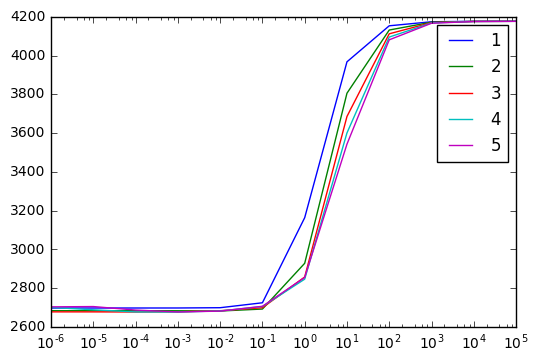

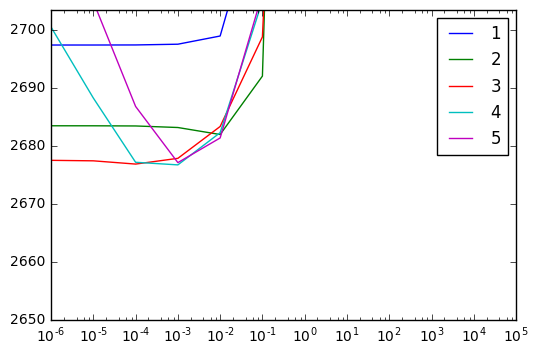

In [53]:
ax = RMS_Ridge_df.plot(logx=True)

ax = RMS_Ridge_df.plot(logx=True)
ax.set_ylim((RMS_Ridge_min - RMS_Ridge_min*0.01, RMS_Ridge_min + RMS_Ridge_min*0.01))

### Try with Ridge Regression CV

In [54]:
all_features = ['TotLivSF'] + ['TotLivSF_{}'.format(i) for i in range(2,6)]
print(all_features)

['TotLivSF', 'TotLivSF_2', 'TotLivSF_3', 'TotLivSF_4', 'TotLivSF_5']


Make and train a model for TotLivSF, [TotLivSF, TotLivSF_2], [TotLivSF, TotLivSF_2, TotLivSF_3], ...

Train the models

In [55]:
alphas = np.logspace(-6,5,12)
m_RidgeCV = train_models(sklearn.linear_model.RidgeCV, {'normalize':True, 'alphas':alphas}, train_sub, all_features, ['SalePrice'])

Make predictions with all the models

In [56]:
p_RidgeCV = predict_models(m_RidgeCV, valid, all_features)
p_RidgeCV_train = predict_models(m_RidgeCV, train_sub, all_features)

Visualize the predictions

0: Features = ['TotLivSF']


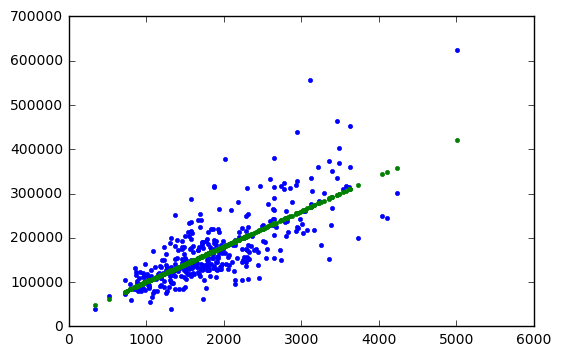

1: Features = ['TotLivSF', 'TotLivSF_2']


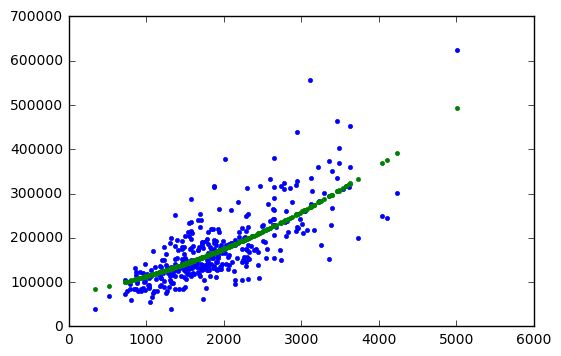

2: Features = ['TotLivSF', 'TotLivSF_2', 'TotLivSF_3']


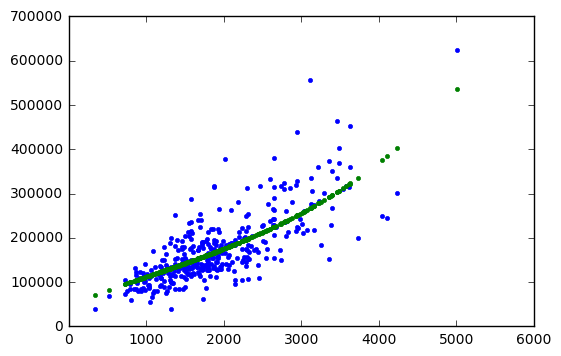

3: Features = ['TotLivSF', 'TotLivSF_2', 'TotLivSF_3', 'TotLivSF_4']


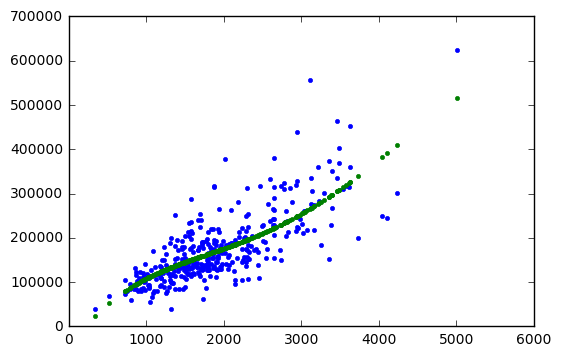

4: Features = ['TotLivSF', 'TotLivSF_2', 'TotLivSF_3', 'TotLivSF_4', 'TotLivSF_5']


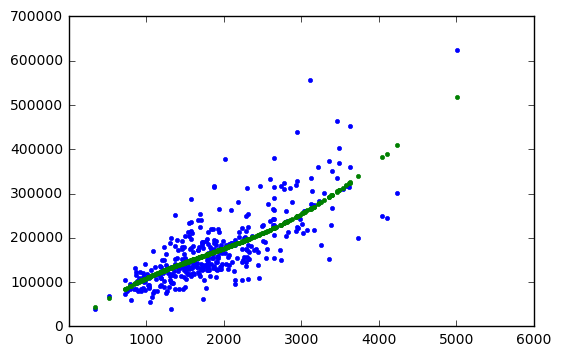

In [57]:
for i in range(len(p_RidgeCV)):
    fs = all_features[:i+1]
    print("{}: Features = {}".format(i, fs))
    visualize_prediction(valid['TotLivSF'], valid['SalePrice'], p_RidgeCV[i])

Evaluate each model on the validation data

In [58]:
RSS_RidgeCV = [None] * len(m_RidgeCV)
RMS_RidgeCV = [None] * len(m_RidgeCV)
for i,m in enumerate(m_linear):
    RSS_RidgeCV[i] = get_RSS(valid[['SalePrice']], p_RidgeCV[i])
    RMS_RidgeCV[i] = get_RMS(valid[['SalePrice']], p_RidgeCV[i])
    print("{}: RSS={:8e}, RMS={:8.2f}".format(i, RSS_RidgeCV[i], RMS_RidgeCV[i]))

0: RSS=9.640471e+11, RMS= 2697.41
1: RSS=9.530227e+11, RMS= 2681.95
2: RSS=9.501012e+11, RMS= 2677.83
3: RSS=9.575055e+11, RMS= 2688.25
4: RSS=9.564707e+11, RMS= 2686.79


In [59]:
for m in m_RidgeCV:
    print(m.alpha_)

0.0001
0.01
0.001
1e-05
0.0001


### Try with Ridge Regression CV on entire train set (train_sub+valid). 
I think this is the more appropriate, since we have an implicit validation set with the cross validation

In [60]:
all_features = ['TotLivSF'] + ['TotLivSF_{}'.format(i) for i in range(2,6)]
print(all_features)

['TotLivSF', 'TotLivSF_2', 'TotLivSF_3', 'TotLivSF_4', 'TotLivSF_5']


Make and train a model for TotLivSF, [TotLivSF, TotLivSF_2], [TotLivSF, TotLivSF_2, TotLivSF_3], ...

Train the models

In [61]:
alphas = np.logspace(-6,5,12)
m_RidgeCV = train_models(sklearn.linear_model.RidgeCV, {'normalize':True, 'alphas':alphas}, train, all_features, ['SalePrice'])

Make predictions with all the models

In [62]:
p_RidgeCV = predict_models(m_RidgeCV, train, all_features)

Visualize the predictions

0: Features = ['TotLivSF']


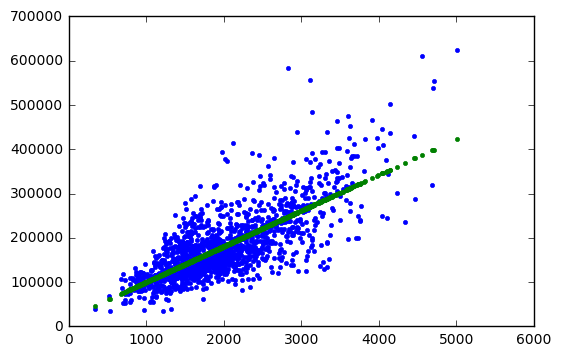

1: Features = ['TotLivSF', 'TotLivSF_2']


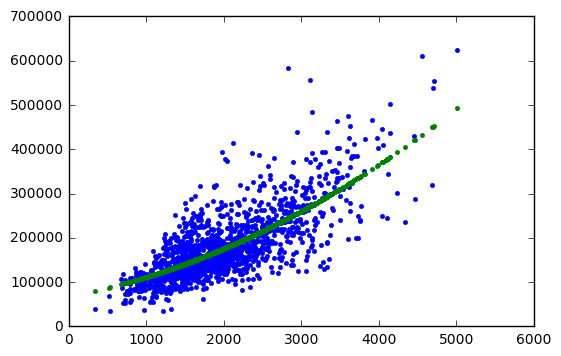

2: Features = ['TotLivSF', 'TotLivSF_2', 'TotLivSF_3']


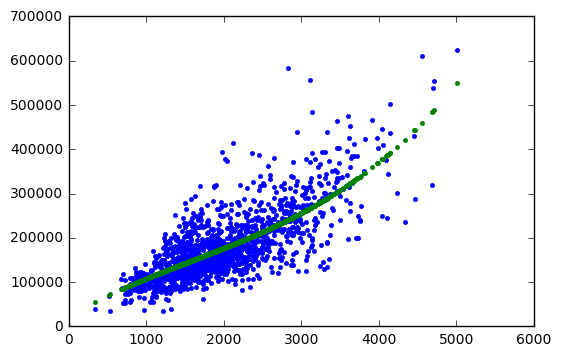

3: Features = ['TotLivSF', 'TotLivSF_2', 'TotLivSF_3', 'TotLivSF_4']


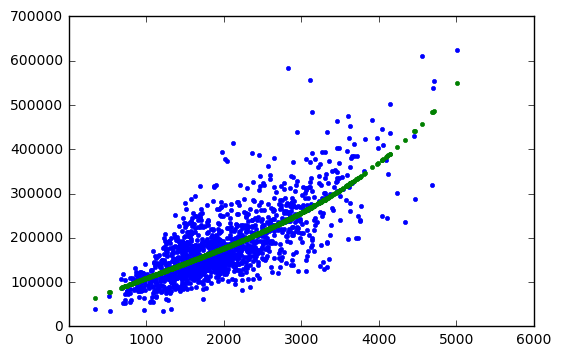

4: Features = ['TotLivSF', 'TotLivSF_2', 'TotLivSF_3', 'TotLivSF_4', 'TotLivSF_5']


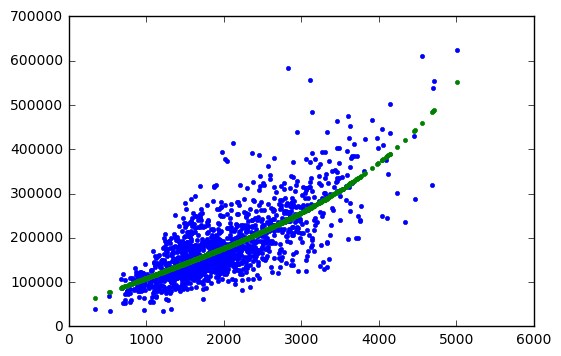

In [63]:
for i in range(len(p_RidgeCV)):
    fs = all_features[:i+1]
    print("{}: Features = {}".format(i, fs))
    visualize_prediction(train['TotLivSF'], train['SalePrice'], p_RidgeCV[i])

Evaluate each model on the validation data

In [64]:
RSS_RidgeCV = [None] * len(m_RidgeCV)
RMS_RidgeCV = [None] * len(m_RidgeCV)
for i,m in enumerate(m_RidgeCV):
    RSS_RidgeCV[i] = get_RSS(train[['SalePrice']], p_RidgeCV[i])
    RMS_RidgeCV[i] = get_RMS(train[['SalePrice']], p_RidgeCV[i])
    print("{}: RSS={:8e}, RMS={:8.2f}".format(i, RSS_RidgeCV[i], RMS_RidgeCV[i]))

0: RSS=3.816676e+12, RMS= 1342.70
1: RSS=3.729954e+12, RMS= 1327.36
2: RSS=3.706495e+12, RMS= 1323.18
3: RSS=3.709723e+12, RMS= 1323.76
4: RSS=3.710079e+12, RMS= 1323.82


In [65]:
for m in m_RidgeCV:
    print(m.alpha_)

0.0001
0.01
0.0001
0.001
0.001


Thus, RidgeCV's best model is the 3 feature ['TotLivSF', 'TotLivSF_2', 'TotLivSF_3'] (index 2) model using alpha=0.0001 for Ridge Regression

Make predictions for the test dataset with this model:

Test to make sure I do this right... should be the same as above's best RMS 

In [66]:
fs = ['TotLivSF', 'TotLivSF_2', 'TotLivSF_3']
test_predictions_RidgeCV = m_RidgeCV[2].predict(train[fs])
get_RMS(train[['SalePrice']], test_predictions_RidgeCV)

1323.1793943745263

Now for real:

In [67]:
fs = ['TotLivSF', 'TotLivSF_2', 'TotLivSF_3']
test_predictions_RidgeCV = pd.DataFrame(m_RidgeCV[2].predict(test[fs]), index=test.index, columns=['SalePrice'])
test_predictions_RidgeCV.index.name = "Id"

In [68]:
print(test_predictions_RidgeCV)

          SalePrice
Id                 
1461  143492.397034
1462  195118.375027
1463  207685.490289
1464  191764.940237
1465  145865.936882
1466  153456.170288
1467  185724.618500
1468  140572.595521
1469  175582.233948
1470  160861.773472
1471  205249.687068
1472  118377.817287
1473  135600.866392
1474  175025.420642
1475   96124.500156
1476  201185.772370
1477  145933.724234
1478  163863.971504
1479  166739.547899
1480  381343.540079
1481  240915.436920
1482  135737.395883
1483  130945.368756
1484  119641.940045
1485  156509.380014
1486  158751.770851
1487  211922.801342
1488  149389.788896
1489  123622.223201
1490  245667.791171
...             ...
2890   81094.037782
2891  152303.691280
2892   87979.684417
2893  135873.905133
2894  103536.649470
2895  291393.785584
2896  276732.667124
2897  206236.688633
2898  154066.482728
2899  142338.646940
2900  162361.684961
2901  218526.687494
2902  226287.076631
2903  287042.152499
2904  285259.439825
2905  149728.571287
2906  222700.698191


See how this model does with the one really large house...

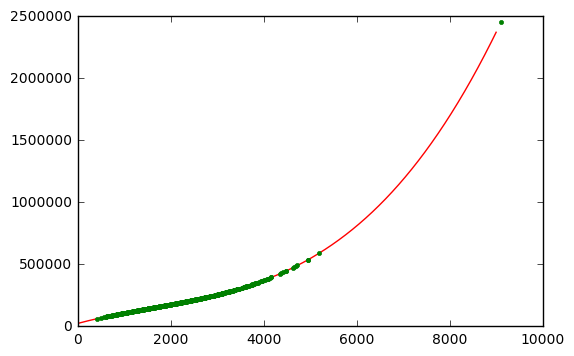

In [69]:
df = pd.DataFrame({'TotLivSF':   [i**1 for i in range(0,9000)],
                   'TotLivSF_2': [i**2 for i in range(0,9000)],
                   'TotLivSF_3': [i**3 for i in range(0,9000)],
                   'TotLivSF_4': [i**4 for i in range(0,9000)],

})
sample_predictions_RidgeCV = pd.DataFrame(m_RidgeCV[2].predict(df[fs]), columns=['SalePrice'])
plt.plot(#test['TotLivSF'], test['SalePrice'], 'b.',
         df['TotLivSF'], sample_predictions_RidgeCV, 'r-',
         test['TotLivSF'], test_predictions_RidgeCV['SalePrice'], 'g.')


Nailed it! ...maybe?

In [70]:
test_predictions_RidgeCV.to_csv('test_predictions_RidgeCV_1.csv')